In [1]:
import numpy as np
from random import expovariate as exprandom
from matplotlib import pyplot as plt
from math import sin

## Вспомогательные фукнции

In [2]:
# ф-ция для изменения интенсивности поступления новых заявок в зависимости от модельного времени суток
def lam_t(x, Lam):
    '''
    x - момент модельного времени суток (в часах)
    Lam - максимальная интенсивность
    '''
    return Lam * (0.7 + 0.3*sin((x-4)*np.pi/12 - np.pi/2)) # то есть от 40% (в 4 часа утра) до 100% (примерно в 16:00)

# ф-ция аналог фукнции append, но для строки внутри словаря
def dictappend(dict_part, app):
    '''
    dict_part - список, в который нужно добавить значение
    app - добавляемое значение
    '''
    dict_part.append(app)
    return dict_part

# ф-ция аналог фукнции pop, но для строки внутри словаря
def dictpop(dict_part, popindex):
    '''
    dict_part - список, из которого нужно удалить значение
    popindex - индекс удаляемого значения
    '''
    dict_part.pop(popindex)
    return dict_part

# ф-ция для перерасчета моментов окончания обслуживания после поступления/ухода заявок отдельного виртуального оператора (далее ВО)
def raspredelenie(moment, Mu, R, old_res_value, N, Rmax, maxGB, minB):
    '''
    moment - момент модельного времени
    Mu - словарь списков окончания облуживания заявок по типам
    R - объем "свободного" ресурса до перераспреления
    old_res_value - распределение ресурса до вызова функции
    N - количество заявок на приборах (тут уже новые N, после увеличения/уменьшения и не важно на сколько)
    Rmax - максимальный объём ресурса оператора
    maxGB - максимальный порог заявок GB
    minB - набор минимальных требований
    '''
    new_res_value = {'GB':0,'BG':Rmax}
    n = N['GB'] + N['BG']
    
    if n != 0:
        if int(R/n) > (maxGB-minB['GB']):
            R2 = R - (maxGB-minB['GB'])*N['GB']
            
            if N['GB'] != 0:
                new_res_value['GB'] = maxGB
            
            if N['BG'] != 0:
                new_res_value['BG'] = minB['BG'] + int(R2/(N['BG'])) # может немного и неправильно присваивать, но если их и нет, то ничего всё равно не будет(вроде(проверить потом при маленьком timelim)
        else:
            new_res_value['GB'] = minB['GB'] + int(R/n)
            new_res_value['BG'] = minB['BG'] + int(R/n)
        
        for i in range(N['BG']):
            Mu['BG'][i] = moment + (Mu['BG'][i]-moment)*old_res_value['BG']/new_res_value['BG']
    
    return Mu['BG'], new_res_value

# ф-ция для распределения общего ресурса между ВО
def ResourceSharing(N, Q, MNOmax, minB):
    '''
    N - обслуживаемые заявки каждого ВО
    Q - состояния очередей каждого ВО
    MNOmax - объем обшего ресурса
    minB - набор минимальных требований
    '''
    s = []
    n = 0
    M3 = MNOmax
    ind = np.zeros(4)
    
    for i in N.keys():
        # определяем количество заявок на обслуживании и зарезервированный ими минимальный объем ресурса
        n += N[i]['GB'] + N[i]['BG']
        s.append((N[i]['GB'] + len(Q[i]['GB']))*minB[i]['GB'] + (N[i]['BG'] + len(Q[i]['BG']))*minB[i]['BG']) # массив требуемых ВО минимумов ресурса на ослуживание сразу всех имеющихся в их системе заявок(в том числе и тех, что в очереди)
        M3 -= N[i]['GB']*minB[i]['GB'] + N[i]['BG']*minB[i]['BG']
        
        if N[i]['GB'] == 0 and N[i]['BG'] == 0:
            M3 -= 0.1*MNOmax
            ind[int(str(i)[-1])] = 1
    
    if sum(s)*1.33 < MNOmax:
        # можно включать энергосбережение и отключить часть ресурсов
        M3 = sum(s)*1.33 - (MNOmax - M3)  # в скобках та часть, что уже занята обслуживаемыми заявками или зарезервировано пустующими VNO
    
    if n !=0:
        ss = np.zeros(3)
        
        if sum(s) != 0:
            for i in range(3):
                ss[i] = s[i]/sum(s)
        # распеределение общего ресурса по всем ВО
        vno1 = N['VNO1']['GB']*minB['VNO1']['GB'] + N['VNO1']['BG']*minB['VNO1']['BG'] + 0.1*MNOmax*ind[1] + M3*s[0]/sum(s)
        vno2 = N['VNO2']['GB']*minB['VNO2']['GB'] + N['VNO2']['BG']*minB['VNO2']['BG'] + 0.1*MNOmax*ind[2] + M3*s[1]/sum(s)
        vno3 = N['VNO3']['GB']*minB['VNO3']['GB'] + N['VNO3']['BG']*minB['VNO3']['BG'] + 0.1*MNOmax*ind[3] + M3*s[2]/sum(s)
        # определение объема "свободного" ресурса для каждого ВО
        r1 = vno1 - (N['VNO1']['GB']*minB['VNO1']['GB'] + N['VNO1']['BG']*minB['VNO1']['BG'])
        r2 = vno2 - (N['VNO2']['GB']*minB['VNO2']['GB'] + N['VNO2']['BG']*minB['VNO2']['BG'])
        r3 = vno3 - (N['VNO3']['GB']*minB['VNO3']['GB'] + N['VNO3']['BG']*minB['VNO3']['BG'])
        
        return {'VNO1':vno1,'VNO2':vno2,'VNO3':vno3}, {'VNO1':r1,'VNO2':r2,'VNO3':r3}
    
    else:
        # если заявок в системе нет, то возвращаемся к начальному состоянию
        return {'VNO1':MNOmax/3,'VNO2':MNOmax/3,'VNO3':MNOmax/3}, {'VNO1': MNOmax/3,'VNO2': MNOmax/3,'VNO3': MNOmax/3} # Rmax и R

# ф-ция для проверки отдельного ВО на возможность поступления заявки из очереди на обслуживание
def CheckQueue(model_time, Mu, Q, R, minB, WaStTi, Nn, StTi, Volume, res, SWT, SST, N):
    '''
    model_time - момент модельного времени
    Mu - окончания облуживания заявок по типам
    Q - очередь
    R - объем "свободного" ресурса до перераспреления
    minB - набор минимальных требований
    WaStTi - моменты начала ожидания в очереди
    Nn - вспомогательный к SST и SWT счетчик количеств заявок
    StTi - моменты начала обслуживания
    Volume - параметры для определения продолжительностей обслуживания
    res - распреление ресурса ВО по заявкам
    SWT - счетчик для нахождения среднего времени ожидания
    SST - счетчик для вычисления среднего времени обслуживания
    N - обслуживаемые заявки
    '''
    for i in Q.keys():
        while len(Q[i])!=0 and R > minB[i]: 
            SWT[i] += model_time - WaStTi[i][0]
            Nn['SWT'][i] += 1
            WaStTi[i] = dictpop(WaStTi[i],0)
            Q[i] = dictpop(Q[i],0)
            
            if i == 'BG':
                Mu[i] = dictappend(Mu[i], model_time+np.random.uniform(Volume[i][0],Volume[i][1])/res[i]) #usechlognorm(Volume[i][0],Volume[i][1],Volume[i][2])/res[i])  ###
            else:
                Mu[i] = dictappend(Mu[i], model_time+exprandom(Volume[i])) 
            
            StTi[i] = dictappend(StTi[i],model_time)
            N[i] += 1
            R -= minB[i]
    
    return Mu, Q, R, WaStTi, Nn, StTi, res, SWT, SST, N

# ф-ция для обработки окончаний обслуживания заявок после переноса счетчика модельного времени (специфика текущего варианта реализации счетчика модельного времени)
def Checking(model_time, Mu, res, SQ, res_value, R, N, StTi, Nn, SST, SWT, WaStTi, Q, minB, maxGB, Rmax, Volume, Tmax):
    '''
    model_time - момент модельного времени
    Mu - окончания облуживания заявок по типам
    res - распреление ресурса ВО по заявкам
    SQ - счетчик для нахождения средней длины очереди
    res_value - распределение ресурса по заявкам
    R - объем "свободного" ресурса до перераспреления
    N - обслуживаемые заявки
    StTi - моменты начала обслуживания
    Nn - вспомогательный к SST и SWT счетчик количеств заявок
    SST - счетчик для вычисления среднего времени обслуживания
    SWT - счетчик для нахождения среднего времени ожидания
    WaStTi - моменты начала ожидания в очереди
    Q - очередь
    minB - набор минимальных требований
    maxGB - максимальный порог заявок GB
    Rmax - максимальный объём ресурса оператора
    Volume - параметры для определения продолжительностей обслуживания
    Tmax - ограничение по модельному времени
    '''
    # пока остаются выщедшие за это время заявки будем   роверяем вышла ли за это время хоть одна заявка любого типа
    while any(x < model_time and x < Tmax for x in Mu['GB']) or any(x < model_time and x < Tmax for x in Mu['BG']):
        minnow = Tmax
        
        for i in Mu.keys():
            for j in range(len(Mu[i])):
                if Mu[i][j] < minnow:
                    # в итоге получим какого типа(Apl) вышла заявка, когда(minnow) и где она в своём массиве хранится (J)
                    minnow = Mu[i][j]
                    Apl = i
                    J = j
        
        SST[Apl] += Mu[Apl][J] - StTi[Apl][J]
        Nn['SST'][Apl] += 1
        StTi[Apl] = dictpop(StTi[Apl],J)
        Mu[Apl] = dictpop(Mu[Apl],J)
        N[Apl] -= 1
        R += minB[Apl]
        
        Mu, Q, R, WaStTi, Nn, StTi, res, SWT, SST, N = CheckQueue(model_time,Mu,Q,R,minB,WaStTi,Nn,StTi,Volume,res, SWT, SST, N)
        Mu['BG'], res_value = raspredelenie(minnow,Mu, R, res_value, N, Rmax, maxGB, minB)
        
        res['BG'] = res_value['BG']
    
    return Mu, res, SQ, res_value, R, N, StTi, Nn, SST, SWT, WaStTi, Q

## Основная функция симуляции

In [3]:
def VNO_global(Lam, Volume, Delta, Tmax):
    '''
    Lam - интенсивности поступления заявок по типам каждого ВО
    Volume - параметры для определения продолжительностей обслуживания по типам заявок каждого ВО
    Delta - величина промежутка между общими перераспределениями ресурса между ВО
    Tmax - ограничение по модельному времени
    '''
    # начальные данные
    # общий объем ресурса
    MNOmax = 500*1024
    # объемы ресурса, выделяемые каждому ВО
    Rmax = {'VNO1':MNOmax/3,
            'VNO2':MNOmax/3,
            'VNO3':MNOmax/3}
    # объем "свободного" ресурса каждого ВО
    R = {'VNO1':MNOmax/3,
         'VNO2':MNOmax/3,
         'VNO3':MNOmax/3}
    # набор минимальных требований по типам заявок каждого ВО
    minB = {'VNO1':{'GB':int(0.3*1024), 'BG':1024},
            'VNO2':{'GB':int(0.3*1024), 'BG':1024},
            'VNO3':{'GB':int(0.3*1024), 'BG':1024}}
    # максимальный порог заявок GB для каждого ВО
    maxGB = {'VNO1':5*1024,
             'VNO2':5*1024,
             'VNO3':5*1024}
    # для хранения моментов окончания обслуживания
    Mu = {'VNO1':{'GB': [], 'BG': []},
          'VNO2':{'GB': [], 'BG': []},
          'VNO3':{'GB': [], 'BG': []}}
    # очередь
    Q = {'VNO1':{'GB': [], 'BG': []},
         'VNO2':{'GB': [], 'BG': []},
         'VNO3':{'GB': [], 'BG': []}}
    # для хранения моментов начала обслуживания
    StTi = {'VNO1':{'GB': [], 'BG': []},
            'VNO2':{'GB': [], 'BG': []},
            'VNO3':{'GB': [], 'BG': []}}
    # для хранения моментов начала ожидания в очереди
    WaStTi = {'VNO1':{'GB': [], 'BG': []},
              'VNO2':{'GB': [], 'BG': []},
              'VNO3':{'GB': [], 'BG': []}}
    # максимальная длина очереди(пока одинаковая для обоих, в идеале для BG реализовать в виде буфера)
    Qmax = {'VNO1':{'GB':50, 'BG':50},
            'VNO2':{'GB':50, 'BG':50},
            'VNO3':{'GB':50, 'BG':50}}
    # моменты поступлений следующих заявок каждого типа каждого ВО и момент следующего общего перераспределения ресурса (RS)
    occasion = {'GB1': exprandom(lam_t(7, Lam['VNO1']['GB'])),
                'BG1': exprandom(lam_t(7, Lam['VNO1']['BG'])),
                'GB2': exprandom(lam_t(7, Lam['VNO2']['GB'])),
                'BG2': exprandom(lam_t(7, Lam['VNO2']['BG'])),
                'GB3': exprandom(lam_t(7, Lam['VNO3']['GB'])),
                'BG3': exprandom(lam_t(7, Lam['VNO3']['BG'])),
                'RS': Delta}
    # 
    res_value = {'VNO1':{'GB': 0, 'BG': MNOmax/3},
                 'VNO2':{'GB': 0, 'BG': MNOmax/3},
                 'VNO3':{'GB': 0, 'BG': MNOmax/3}}
    # 
    res = {'VNO1':{'GB': MNOmax/3, 'BG': MNOmax/3},
           'VNO2':{'GB': MNOmax/3, 'BG': MNOmax/3},
           'VNO3':{'GB': MNOmax/3, 'BG': MNOmax/3}}
    
    # счетчики
    # счетчик поступивших заявок(всего, в том числе блокированных)
    All = {'VNO1':{'GB': 0, 'BG': 0},
           'VNO2':{'GB': 0, 'BG': 0},
           'VNO3':{'GB': 0, 'BG': 0}}
    # счетчик заявок на обслуживании
    N = {'VNO1':{'GB': 0, 'BG': 0},
         'VNO2':{'GB': 0, 'BG': 0},
         'VNO3':{'GB': 0, 'BG': 0}}
    # счетчик блокировок
    Block = {'VNO1':{'GB': 0, 'BG': 0},
             'VNO2':{'GB': 0, 'BG': 0},
             'VNO3':{'GB': 0, 'BG': 0}}
    # Sum Waitung Time для нахождения среднего времени ожидания
    SWT = {'VNO1':{'GB': 0, 'BG': 0},
           'VNO2':{'GB': 0, 'BG': 0},
           'VNO3':{'GB': 0, 'BG': 0}}        
    # Sum Service Time для вычисления среднего времени обслуживания
    SST = {'VNO1':{'GB': 0, 'BG': 0},
           'VNO2':{'GB': 0, 'BG': 0},
           'VNO3':{'GB': 0, 'BG': 0}}
    # Sum Queue для нахождения средней длины очереди
    SQ = {'VNO1':{'GB': 0, 'BG': 0},
          'VNO2':{'GB': 0, 'BG': 0},
          'VNO3':{'GB': 0, 'BG': 0}}
    # вспомогательный к SST и SWT счетчик количеств заявок
    Nn = {'VNO1':{'SST':{'GB': 0, 'BG': 0},
                  'SWT':{'GB': 0, 'BG': 0}},
          'VNO2':{'SST':{'GB': 0, 'BG': 0},
                  'SWT':{'GB': 0, 'BG': 0}},
          'VNO3':{'SST':{'GB': 0, 'BG': 0},
                  'SWT':{'GB': 0, 'BG': 0}}}
    # среднний объём условно свободного ресурса
    SRfr = {'VNO1':0, 'VNO2':0, 'VNO3':0}
    
    model_time = 0  # счетчик модельного времени
    while model_time < Tmax: 
        model_time = min(occasion[x] for x in occasion.keys())
        minnow = Tmax
        
        for i in occasion.keys():
            if occasion[i] < minnow:
                now_oc = str(i)
                minnow = occasion[i]
        
        if now_oc == 'RS': # момент перераспредления ресурса между VNO
            Rmax, R = ResourceSharing(N,Q,MNOmax,minB)
            
            for i in Mu.keys():  # <=> ['VNO1','VNO2','VNO3']:
                Mu[i], Q[i], R[i], WaStTi[i], Nn[i], StTi[i], res[i], SWT[i], SST[i], N[i] = CheckQueue(model_time,Mu[i],Q[i],R[i],minB[i],WaStTi[i],Nn[i],StTi[i],Volume[i],res[i], SWT[i], SST[i], N[i])  # проверка на случай если этому ВО дали больше ресурса, чем до этого и она может уместить ещё одну заявку
                Mu[i]['BG'], res_value[i] = raspredelenie(model_time,Mu[i], R[i], res_value[i], N[i], Rmax[i], maxGB[i], minB[i])
                Mu[i], res[i], SQ[i], res_value[i], R[i], N[i], StTi[i], Nn[i], SST[i], SWT[i], WaStTi[i], Q[i] = Checking(model_time, Mu[i], res[i], SQ[i], res_value[i], R[i], N[i], StTi[i], Nn[i], SST[i], SWT[i], WaStTi[i], Q[i], minB[i], maxGB[i], Rmax[i], Volume[i], Tmax)
            
            occasion['RS'] = model_time + Delta
        
        elif len(now_oc) == 3:  # поступление новой заявки
            vno_num = str('VNO'+now_oc[2])
            
            # записываем время поступления следующей заявки этого типа
            occasion[now_oc] = model_time + exprandom(lam_t(7+model_time/3600, Lam[vno_num][now_oc[:-1]]))
            
            now_oc = str(now_oc[:-1])
            All[vno_num][now_oc] += 1
            
            # проверка состояния системы на момент time+dt, вышло ли что-нибудь за это время
            Mu[vno_num], res[vno_num], SQ[vno_num], res_value[vno_num], R[vno_num], N[vno_num], StTi[vno_num], Nn[vno_num], SST[vno_num], SWT[vno_num], WaStTi[vno_num], Q[vno_num] = Checking(model_time, Mu[vno_num], res[vno_num], SQ[vno_num], res_value[vno_num], R[vno_num], N[vno_num], StTi[vno_num], Nn[vno_num], SST[vno_num], SWT[vno_num], WaStTi[vno_num], Q[vno_num], minB[vno_num], maxGB[vno_num], Rmax[vno_num], Volume[vno_num], Tmax)
            
            # поступление новой заявки:
            if R[vno_num] > minB[vno_num][now_oc]:
                # если ресурса достаточно, попадает на прибор
                N[vno_num][now_oc] += 1
                R[vno_num] -= minB[vno_num][now_oc]
                
                if now_oc != 'GB':
                    Mu[vno_num][now_oc] = dictappend(Mu[vno_num][now_oc], model_time + np.random.uniform(Volume[vno_num][now_oc][0],Volume[vno_num][now_oc][1])/res[vno_num][now_oc]) #usechlognorm(Volume[now_apl][0],Volume[now_apl][1],Volume[now_apl][2])/res[now_apl])
                else:
                    Mu[vno_num][now_oc] = dictappend(Mu[vno_num][now_oc], model_time + exprandom(Volume[vno_num][now_oc]))
                
                StTi[vno_num][now_oc] = dictappend(StTi[vno_num][now_oc],model_time)
                Mu[vno_num]['BG'], res_value[vno_num] = raspredelenie(model_time,Mu[vno_num], R[vno_num], res_value[vno_num], N[vno_num], Rmax[vno_num], maxGB[vno_num], minB[vno_num])
                res[vno_num]['BG'] = res_value[vno_num]['BG']
            
            else:
                # если в очереди есть место, поступает в очередь
                if len(Q[vno_num][now_oc]) < Qmax[vno_num][now_oc]:
                    Q[vno_num][now_oc] = dictappend(Q[vno_num][now_oc], model_time)
                    WaStTi[vno_num][now_oc] = dictappend(WaStTi[vno_num][now_oc],model_time)
                else:
                    Block[vno_num][now_oc] += 1
            
            SRfr[vno_num] += R[vno_num]
            SQ[vno_num][now_oc] += len(Q[vno_num][now_oc])
    
    for v in WaStTi.keys():
        for t in WaStTi[v].keys():
            for j in WaStTi[v][t]:
                SWT[v][t] += j
                Nn[v]['SWT'][t] += 1
                
    return All, Block, SQ, SST, SWT, SRfr, Nn

## Параметры

In [4]:
D = [5, 10, 20, 30, 40, 50]  # перебираемые дельты (промежутки между общим перераспределением ресурса между ВО)
Lam = []     # интенсивности поступления заявок
Volume = []  # средняя продолжительность обслуживания GB и ограничения для генераций размеров BG
for n in range(2,15):
    Lam.append({'VNO1':{'GB': 0.6 * n*0.5,'BG':0.4 * n*0.5},'VNO2':{'GB': 0.6 * (1.5*n*0.5),'BG':0.4 * (1.5*n*0.5)},'VNO3':{'GB': 0.6 * (2*n*0.5),'BG':0.4 * (2*n*0.5)}}) #интенсивности потупления заявок
    Volume.append({'VNO1':{'GB':1/(20*n*0.5),'BG':[100*1024,500*1024]}, 'VNO2':{'GB':1/(20*n*0.5),'BG':[25*1024,100*1024]},'VNO3':{'GB':1/(20*n*0.5),'BG':[1024,20*1024]}})

## Запуск моделирования и отрисовка графиков

In [5]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

i = 0 :
итерация пройдена за 7.405649423599243 секунд
итерация пройдена за 7.655873775482178 секунд
итерация пройдена за 8.031786918640137 секунд
итерация пройдена за 8.294883489608765 секунд
итерация пройдена за 8.765971660614014 секунд
итерация пройдена за 8.719332695007324 секунд
итерация пройдена за 9.300638198852539 секунд
итерация пройдена за 9.487805604934692 секунд
итерация пройдена за 9.64515209197998 секунд
итерация пройдена за 9.971993923187256 секунд
итерация пройдена за 10.280746698379517 секунд
итерация пройдена за 12.644149541854858 секунд
итерация пройдена за 10.582552671432495 секунд
i = 1 :
итерация пройдена за 13.88901972770691 секунд
итерация пройдена за 14.255521059036255 секунд
итерация пройдена за 14.609440326690674 секунд
итерация пройдена за 15.3273446559906 секунд
итерация пройдена за 15.918532371520996 секунд
итерация пройдена за 16.445404529571533 секунд
итерация пройдена за 16.838141918182373 секунд
итерация пройдена за 17.413729190826416 секунд
итерация пр

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:80: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


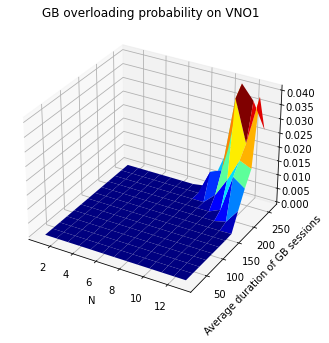

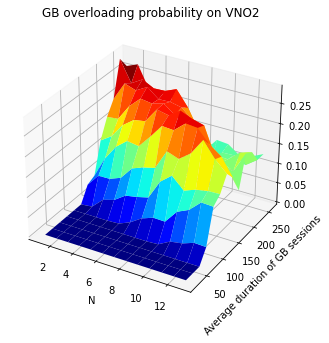

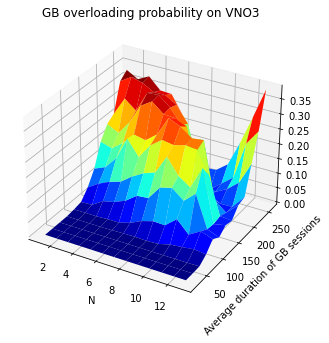

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:89: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


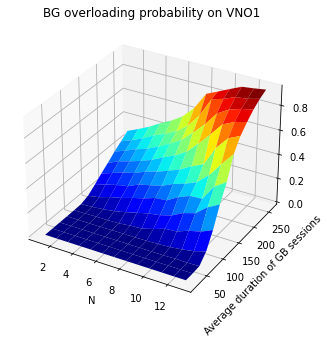

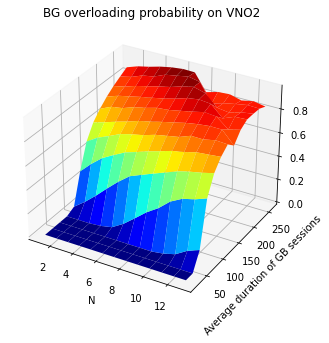

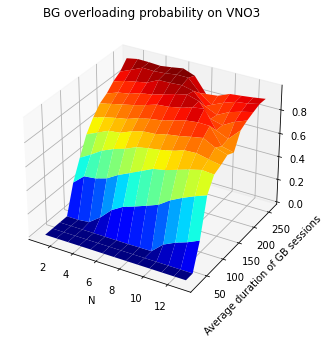

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:98: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


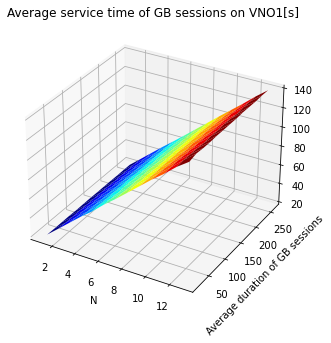

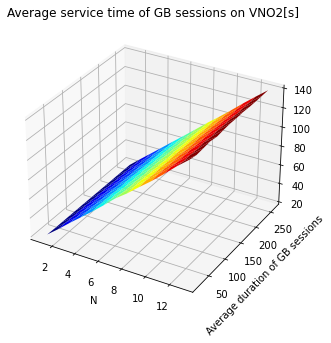

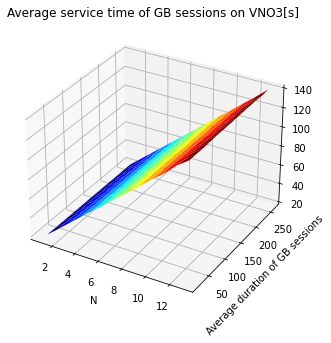

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:107: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


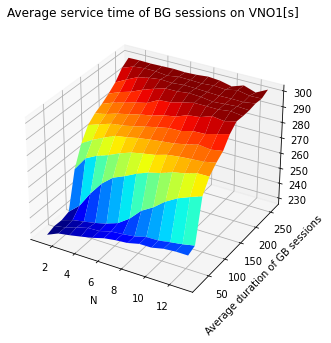

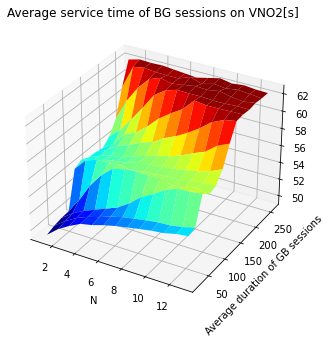

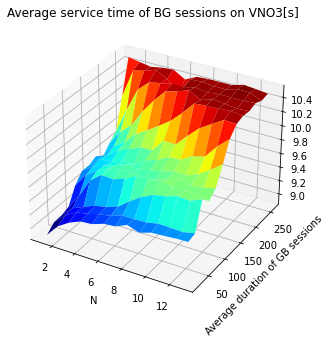

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:116: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


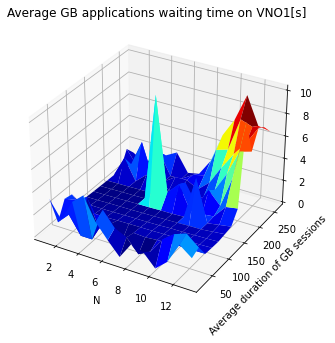

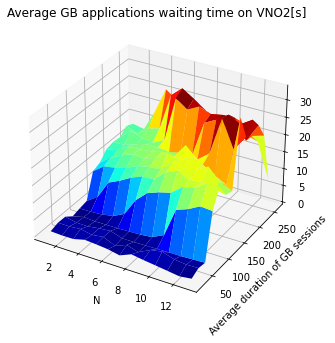

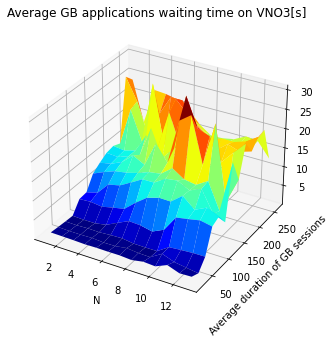

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:125: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


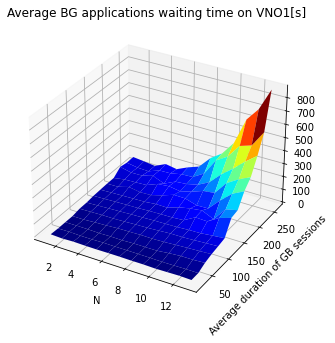

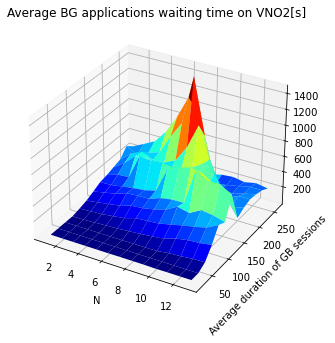

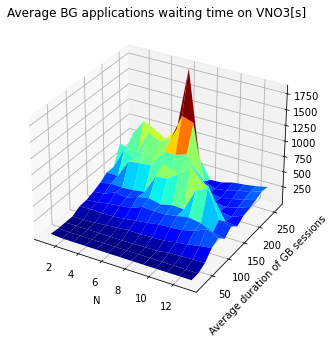

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:134: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


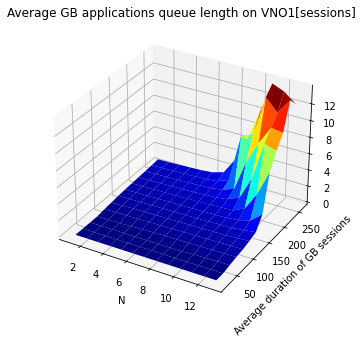

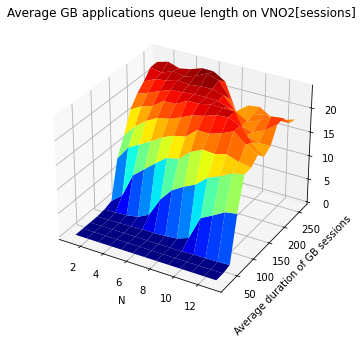

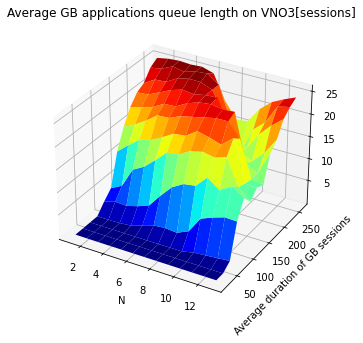

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:143: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


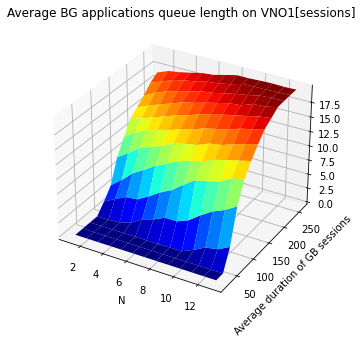

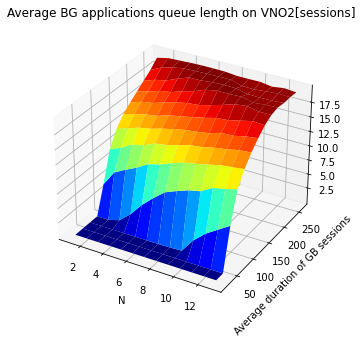

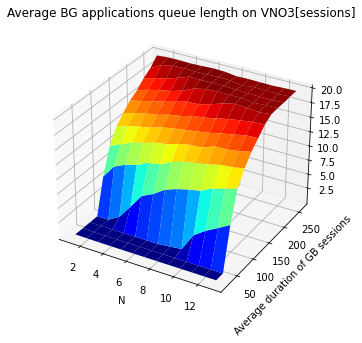

C:\Users\armen\AppData\Local\Temp\ipykernel_3548\3455537610.py:152: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


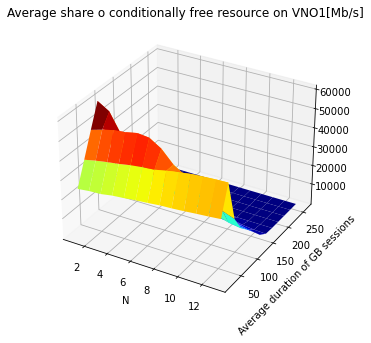

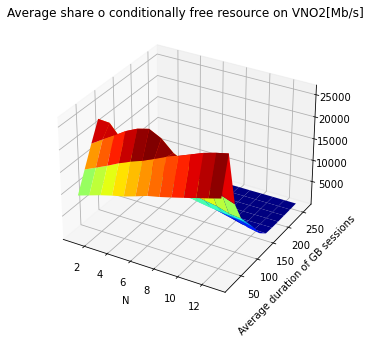

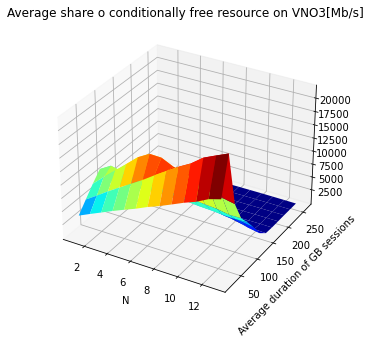

i = 0 :
итерация пройдена за 9.787517309188843 секунд
итерация пройдена за 10.336405754089355 секунд
итерация пройдена за 9.752668380737305 секунд
итерация пройдена за 12.240553855895996 секунд
итерация пройдена за 14.372302532196045 секунд
итерация пройдена за 11.164668321609497 секунд
итерация пройдена за 10.498754024505615 секунд
итерация пройдена за 10.826902151107788 секунд
итерация пройдена за 11.241611003875732 секунд
итерация пройдена за 13.028501272201538 секунд
итерация пройдена за 14.940488815307617 секунд
итерация пройдена за 12.99329948425293 секунд
итерация пройдена за 14.795640230178833 секунд
i = 1 :
итерация пройдена за 17.517929553985596 секунд
итерация пройдена за 16.94603443145752 секунд
итерация пройдена за 19.071134328842163 секунд
итерация пройдена за 20.176031351089478 секунд
итерация пройдена за 17.617348432540894 секунд
итерация пройдена за 18.5819571018219 секунд
итерация пройдена за 19.353380918502808 секунд
итерация пройдена за 19.577114820480347 секунд
ите

In [ ]:
VVV = [20*n for n in range(1,len(Volume)+1)]
X, Y = np.meshgrid(range(1,len(Lam) + 1), VVV)

Zog = np.zeros((3,len(Lam), len(Volume)))
Zob = np.zeros((3,len(Lam), len(Volume)))

Zqg = np.zeros((3,len(Lam), len(Volume)))
Zqb = np.zeros((3,len(Lam), len(Volume)))

Zsg = np.zeros((3,len(Lam), len(Volume)))
Zsb = np.zeros((3,len(Lam), len(Volume)))

Zwg = np.zeros((3,len(Lam), len(Volume)))
Zwb = np.zeros((3,len(Lam), len(Volume)))

Zfr = np.zeros((3,len(Lam), len(Volume)))

START = time.time()  # для вычисления времени работы программы
for delt in D: 
    for i, lam in enumerate(Lam):
        print('i =',i,':')

        for j, vol in enumerate(Volume):
            start = time.time()

            a, b, sq, sst, swt, sr, nn = VNO_global(lam, vol, delt, 87400)

            print('итерация пройдена за', time.time()-start, 'секунд')

            aa1 = a['VNO1']['GB']+a['VNO1']['BG']
            aa2 = a['VNO2']['GB']+a['VNO2']['BG']
            aa3 = a['VNO3']['GB']+a['VNO3']['BG']

            Zog[0][i][j] = b['VNO1']['GB']/a['VNO1']['GB']   # процент заблокированных заявок GB1
            Zob[0][i][j] = b['VNO1']['BG']/a['VNO1']['BG']   # процент заблокированных заявок BG1
            Zog[1][i][j] = b['VNO2']['GB']/a['VNO2']['GB']   # процент заблокированных заявок GB2
            Zob[1][i][j] = b['VNO2']['BG']/a['VNO2']['BG']   # процент заблокированных заявок BG2
            Zog[2][i][j] = b['VNO3']['GB']/a['VNO3']['GB']   # процент заблокированных заявок GB3
            Zob[2][i][j] = b['VNO3']['BG']/a['VNO3']['BG']   # процент заблокированных заявок BG3

            Zqg[0][i][j] = sq['VNO1']['GB']/aa1              # средняя длина очереди GB1
            Zqb[0][i][j] = sq['VNO1']['BG']/aa1              # средняя длина очереди BG1
            Zqg[1][i][j] = sq['VNO2']['GB']/aa2              # средняя длина очереди GB2
            Zqb[1][i][j] = sq['VNO2']['BG']/aa2              # средняя длина очереди BG2
            Zqg[2][i][j] = sq['VNO3']['GB']/aa3              # средняя длина очереди GB3
            Zqb[2][i][j] = sq['VNO3']['BG']/aa3              # средняя длина очереди BG3


            Zsg[0][i][j] = sst['VNO1']['GB']/nn['VNO1']['SST']['GB']   # среднее время обслуживания GB
            Zsb[0][i][j] = sst['VNO1']['BG']/nn['VNO1']['SST']['BG']   # среднее время обслуживания BG
            if nn['VNO1']['SWT']['GB'] != 0:
                Zwg[0][i][j] = swt['VNO1']['GB']/nn['VNO1']['SWT']['GB']  # среднее время ожидания GB
            if nn['VNO1']['SWT']['BG'] != 0:
                Zwb[0][i][j] = swt['VNO1']['BG']/nn['VNO1']['SWT']['BG']  # среднее время ожидания BG

            Zsg[1][i][j] = sst['VNO2']['GB']/nn['VNO2']['SST']['GB']   # среднее время обслуживания GB
            Zsb[1][i][j] = sst['VNO2']['BG']/nn['VNO2']['SST']['BG']   # среднее время обслуживания BG
            if nn['VNO2']['SWT']['GB'] != 0:
                Zwg[1][i][j] = swt['VNO2']['GB']/nn['VNO2']['SWT']['GB']  # среднее время ожидания GB
            if nn['VNO2']['SWT']['BG'] != 0:
                Zwb[1][i][j] = swt['VNO2']['BG']/nn['VNO2']['SWT']['BG']  # среднее время ожидания BG

            Zsg[2][i][j] = sst['VNO3']['GB']/nn['VNO3']['SST']['GB']   # среднее время обслуживания GB
            Zsb[2][i][j] = sst['VNO3']['BG']/nn['VNO3']['SST']['BG']   # среднее время обслуживания BG
            if nn['VNO3']['SWT']['GB'] != 0:
                Zwg[2][i][j] = swt['VNO3']['GB']/nn['VNO3']['SWT']['GB']  # среднее время ожидания GB
            if nn['VNO3']['SWT']['BG'] != 0:
                Zwb[2][i][j] = swt['VNO3']['BG']/nn['VNO3']['SWT']['BG']  # среднее время ожидания BG

            Zfr[0][i][j] = sr['VNO1']/aa1                       # средний объём условно свободного ресурса
            Zfr[1][i][j] = sr['VNO2']/aa2                       # средний объём условно свободного ресурса
            Zfr[2][i][j] = sr['VNO3']/aa3                       # средний объём условно свободного ресурса
    
    print('Все иттерации пройдены за',(time.time()-START)/60,'минут')
    print('Delta =', delt)
    
    # для каждой дельты отдельные графики
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zog[i], cmap = cm.jet)
        plt.title('GB overloading probability on VNO'+str(i+1))
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zob[i], cmap = cm.jet)
        plt.title('BG overloading probability on VNO'+str(i+1))
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zsg[i], cmap = cm.jet)
        plt.title('Average service time of GB sessions on VNO'+str(i+1)+'[s]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zsb[i], cmap = cm.jet)
        plt.title('Average service time of BG sessions on VNO'+str(i+1)+'[s]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zwg[i], cmap = cm.jet)
        plt.title('Average GB applications waiting time on VNO'+str(i+1)+'[s]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zwb[i], cmap = cm.jet)
        plt.title('Average BG applications waiting time on VNO'+str(i+1)+'[s]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zqg[i], cmap = cm.jet)
        plt.title('Average GB applications queue length on VNO'+str(i+1)+'[sessions]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zqb[i], cmap = cm.jet)
        plt.title('Average BG applications queue length on VNO'+str(i+1)+'[sessions]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()
    
    for i in range(3):
        fig = plt.figure()
        axes = Axes3D(fig)
        axes.plot_surface(X, Y, Zfr[i], cmap = cm.jet)
        plt.title('Average share o conditionally free resource on VNO'+str(i+1)+'[Mb/s]')
        plt.xlabel('N')
        plt.ylabel('Average duration of GB sessions')
        plt.show()